# Выбор локации для скважины

# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# План выполнения проекта


1. Загрузим и подготовим данные. 
0. Обучим и проверим модель для каждого региона:
 1. Разобъем данные на обучающую и валидационную выборки в соотношении 75:25.
 0. Обучим модель и сделаем предсказания на валидационной выборке.
 0. Сохраним предсказания и правильные ответы на валидационной выборке.
 0. Напечатаем на экране средний запас предсказанного сырья и RMSE модели.
 0. Проанализируем результаты.
2. Подготовимся к расчёту прибыли:
 1. Все ключевые значения для расчётов сохраним в отдельных переменных.
 0. Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Сравним полученный объём сырья со средним запасом в каждом регионе. 
 0. Напишим выводы по этапу подготовки расчёта прибыли.
3. Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
 1. Выберем скважины с максимальными значениями предсказаний. 
 0. Просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям.
 0. Рассчитаем прибыль для полученного объёма сырья.
4. Посчитайтем риски и прибыль для каждого региона:
 1. Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
 0. Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.
 0. Напишем выводы: предложим регион для разработки скважин и обоснуем выбор.

# Описание данных
Данные геологоразведки трёх регионов находятся в файлах.

* `id` — уникальный идентификатор скважины;
* `f0`, `f1`, `f2` — три признака точек (неважно, что они означают, но сами признаки значимы);
* `product` — объём запасов в скважине (тыс. баррелей).


Условия задачи:
* Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).

* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.

* Бюджет на разработку скважин в регионе — 10 млрд рублей.

* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

# Импорт библиотек

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
from numpy.random import RandomState
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error

# Вводим переменные:

In [2]:
# Введем глобальную переменную для значения random_state
RFN = 12345
STATE_RFN = np.random.RandomState(RFN)
# При разведке региона исследуют 500 точек:
REGION_POINTS = 500
# с помощью машинного обучения выбирают 200 лучших для разработки:
BEST_REGION_POINTS = 200    
# Бюджет на разработку скважин в регионе — 10 млрд рублей:
DEVELOPMENT_BUDGET = 1e07   
# Доход с каждой единицы продукта:
COST_BARREL = 450 
# Количество выборок для метода Bootstrap
QUANTITY_BOOTSTRAP = 1000

## Загрузка и подготовка данных

### Загрузка данных

Загрузим данные, в качестве разделителя будем использовать знак - `,`:

In [3]:
geo_data_0_file_1 = 'geo_data_0.csv'
geo_data_0_file_2 = 'https://code.s3.yandex.net/datasets/geo_data_0.csv'

geo_data_1_file_1 = 'geo_data_1.csv'
geo_data_1_file_2 = 'https://code.s3.yandex.net/datasets/geo_data_1.csv'

geo_data_2_file_1 = 'geo_data_2.csv'
geo_data_2_file_2 = 'https://code.s3.yandex.net/datasets/geo_data_2.csv'

if os.path.exists(geo_data_0_file_1):
    geo_data_0 = pd.read_csv(geo_data_0_file_1)
elif os.path.exists(geo_data_0_file_2):
    geo_data_0 = pd.read_csv(geo_data_0_file_2)
else:
    print('Something is wrong')
    
if os.path.exists(geo_data_1_file_1):
    geo_data_1 = pd.read_csv(geo_data_1_file_1)
elif os.path.exists(geo_data_1_file_2):
    geo_data_1 = pd.read_csv(geo_data_1_file_2)
else:
    print('Something is wrong')
    
if os.path.exists(geo_data_2_file_1):
    geo_data_2 = pd.read_csv(geo_data_2_file_1)
elif os.path.exists(geo_data_2_file_2):
    geo_data_2 = pd.read_csv(geo_data_2_file_2)
else:
    print('Something is wrong')

### Изучение данных

Изучим и подготовим данные к исследованию:

In [4]:
def df_info(df):
    # выведем основную информацию датафрейма с помощью метода info() и describe()
    df.info()
    print("\n" + "Статистическая сводка каждого столбца:" + "\n", df.describe())
    # выведем первые строки датафрейма и размер датафрейма
    print("\n" + "Первые строки датафрейма:" + "\n", df.head())
    print("\n" + "Размер датафрейма:" + "\n"
          "Количество строк:", df.shape[0], "\n"
          "Количество столбцов:", df.shape[1], "\n")
    # выведем количество дублирующих строк датафрейма
    print("Количество явных дубликатов датафрейма:", df.duplicated().sum(), "\n")
    # проверим датафрейм на наличие неявных дубликотов
    # для этого посчитаем количество уникальных значений столбца id и сравним их с количеством строк
    print("Количество неявных дубликатов датафрейма:", len(df) - df['id'].nunique(), "\n")
    #выыдем общую диаграмму для всех признаков датафрейма:
    print("Общая диаграмма для всех признаков датафрейма:")
    fig = df.hist(bins=150, figsize=(20,20), xlabelsize=15, ylabelsize=15);
    [x.title.set_size(20) for x in fig.ravel()]
    # выведем взаимную корреляцию признаков датафрейма и проверим данные на мультиколлинеарность признаков
    plt.figure(figsize = (5,5))
    plt.title('Взаимная корреляция признаков датафрейма для оценки мультиколлинеарности:' + "\n", size=12)
    sns.heatmap(df.select_dtypes(include=['float64']).corr(), annot=True);

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Статистическая сводка каждого столбца:
                   f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.5640

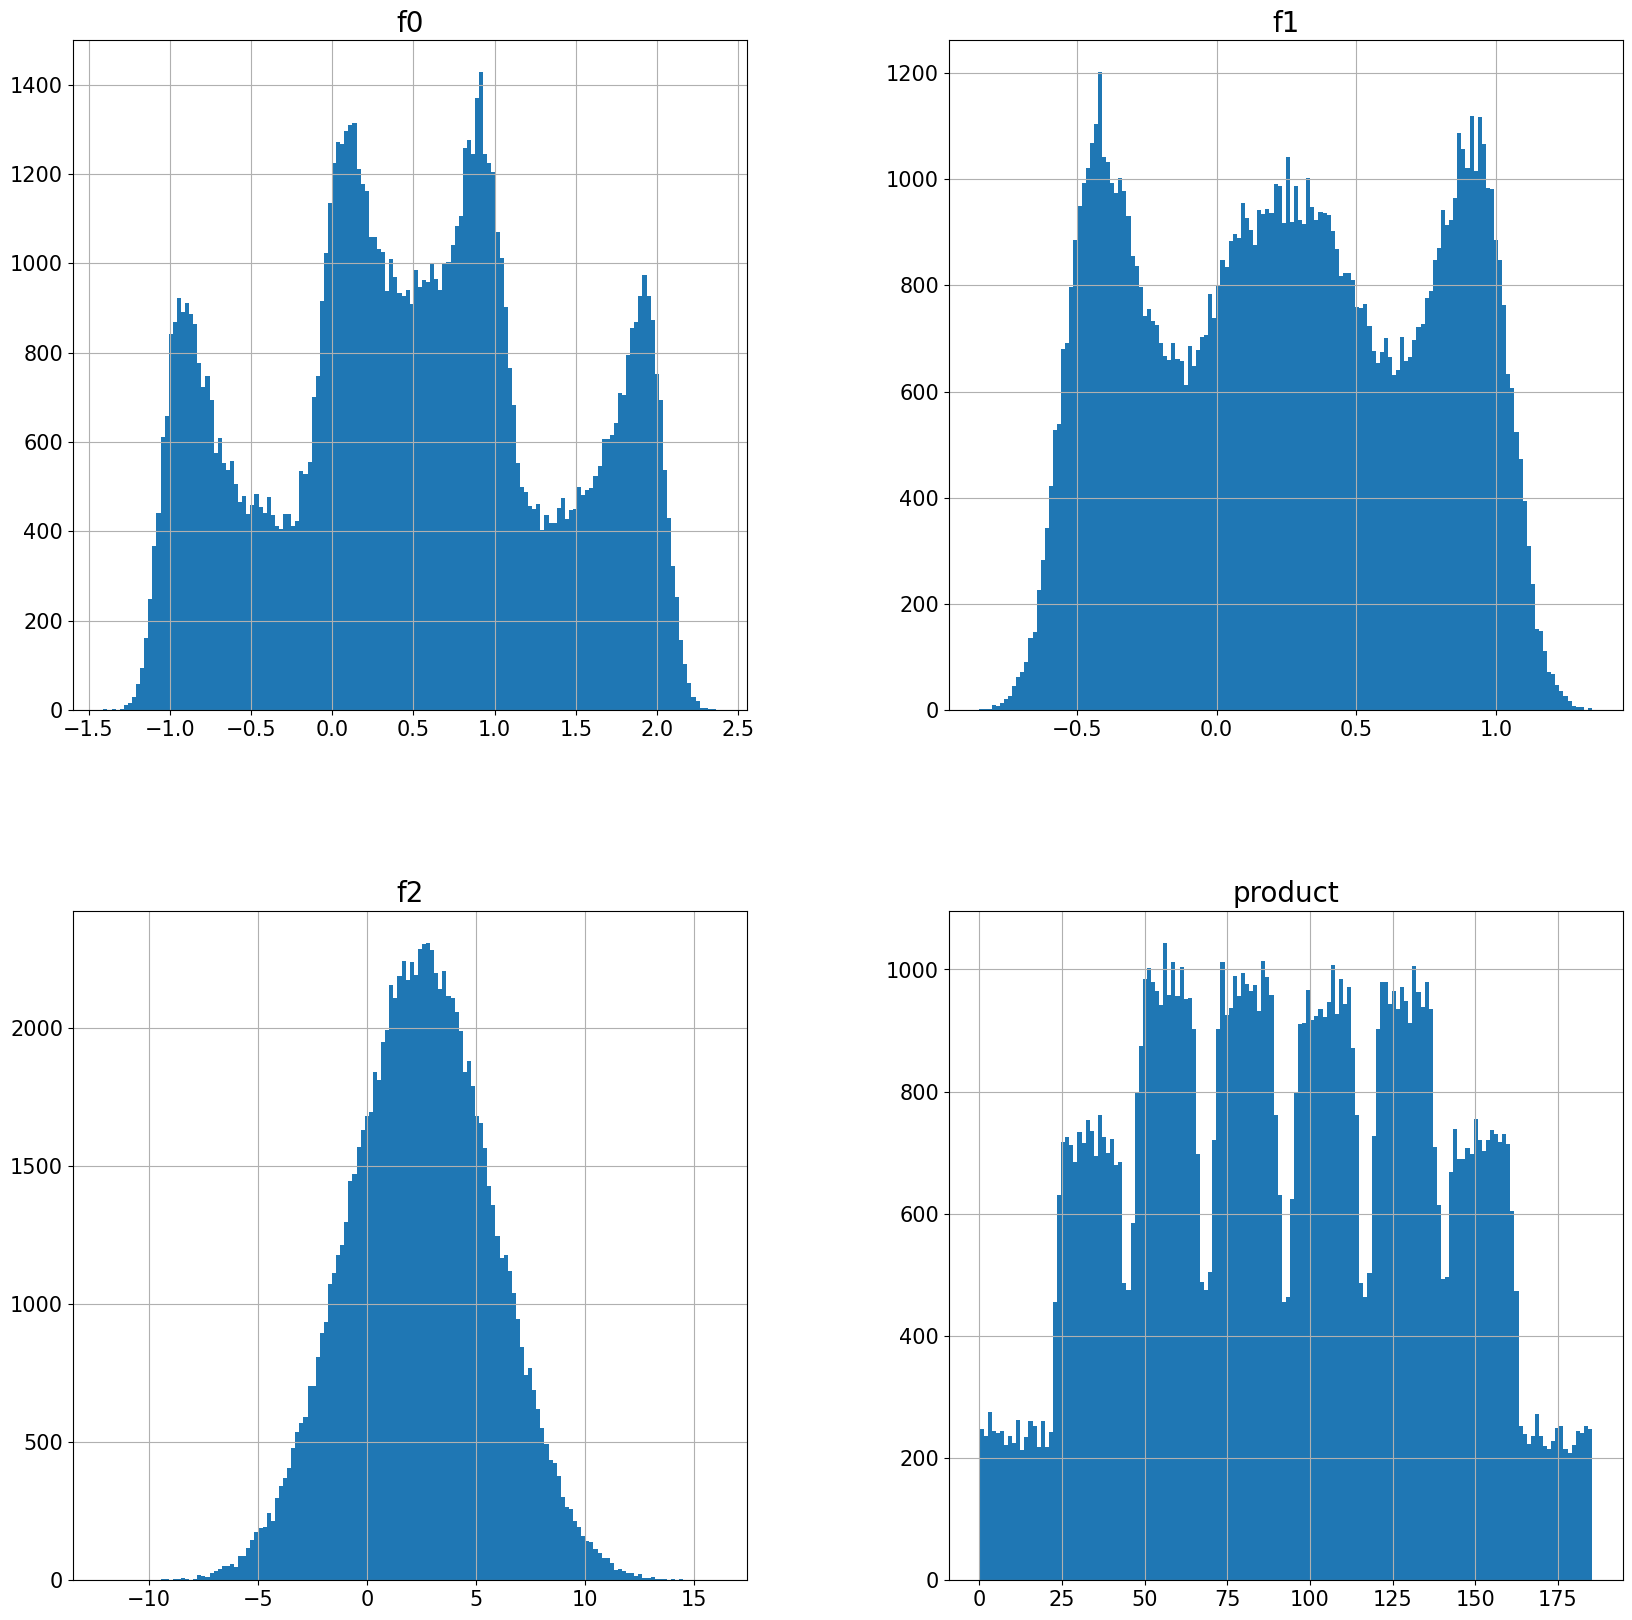

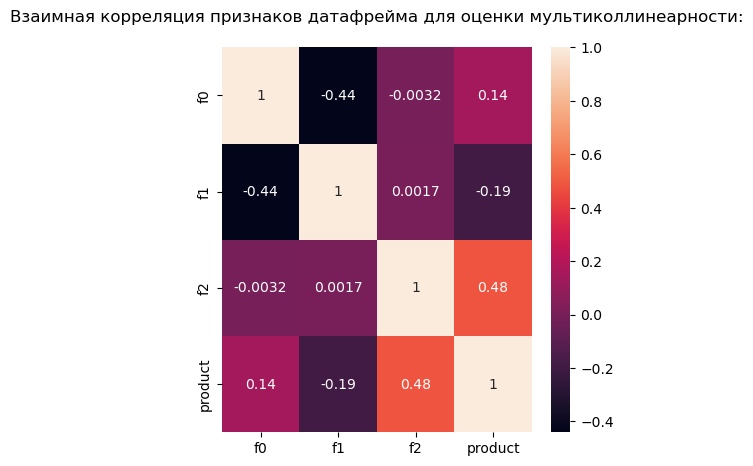

In [5]:
df_info(geo_data_0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Статистическая сводка каждого столбца:
                   f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267985       1.000021      26.953261
50%         1.153055      -4.813172       2.011479      57.085625
75%         8.621015      -1.332816       3.999904     107.8130

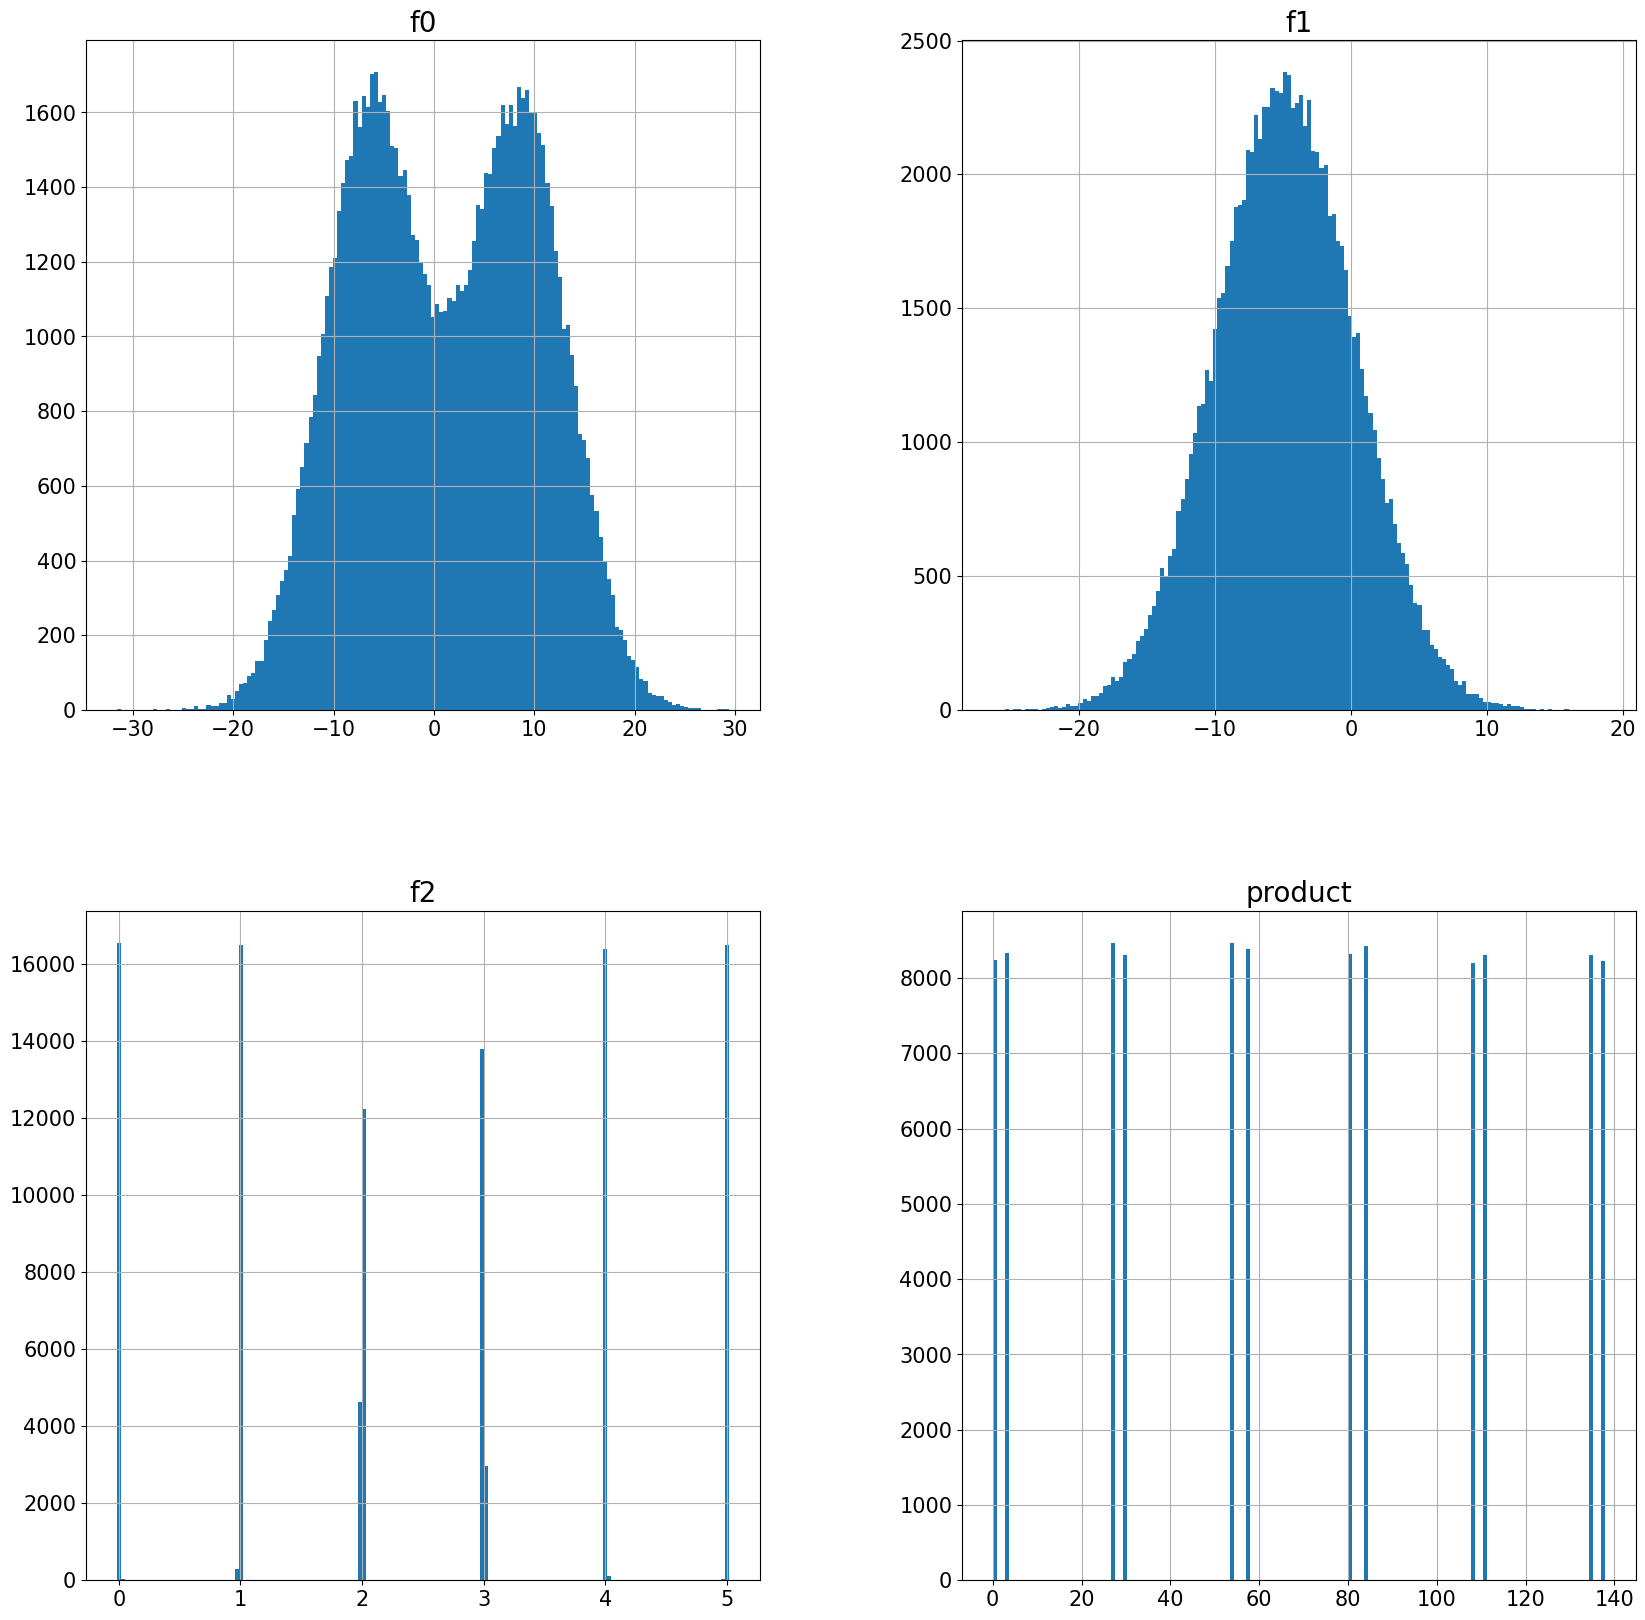

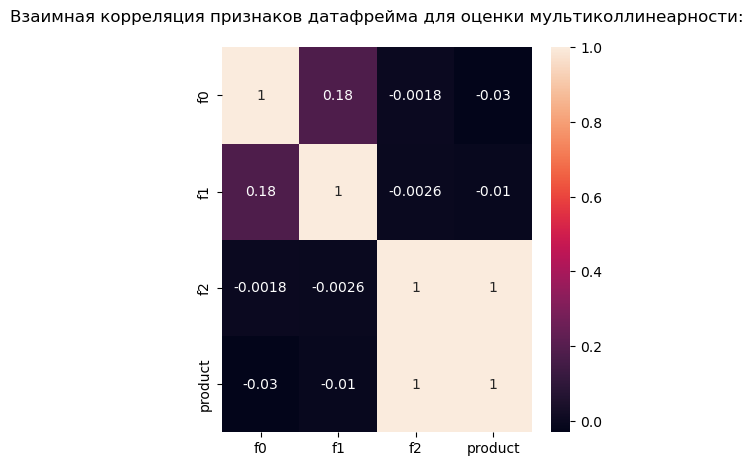

In [6]:
df_info(geo_data_1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB

Статистическая сводка каждого столбца:
                   f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.002023      -0.002081       2.495128      95.000000
std         1.732045       1.730417       3.473445      44.749921
min        -8.760004      -7.084020     -11.970335       0.000000
25%        -1.162288      -1.174820       0.130359      59.450441
50%         0.009424      -0.009482       2.484236      94.925613
75%         1.158535       1.163678       4.858794     130.5950

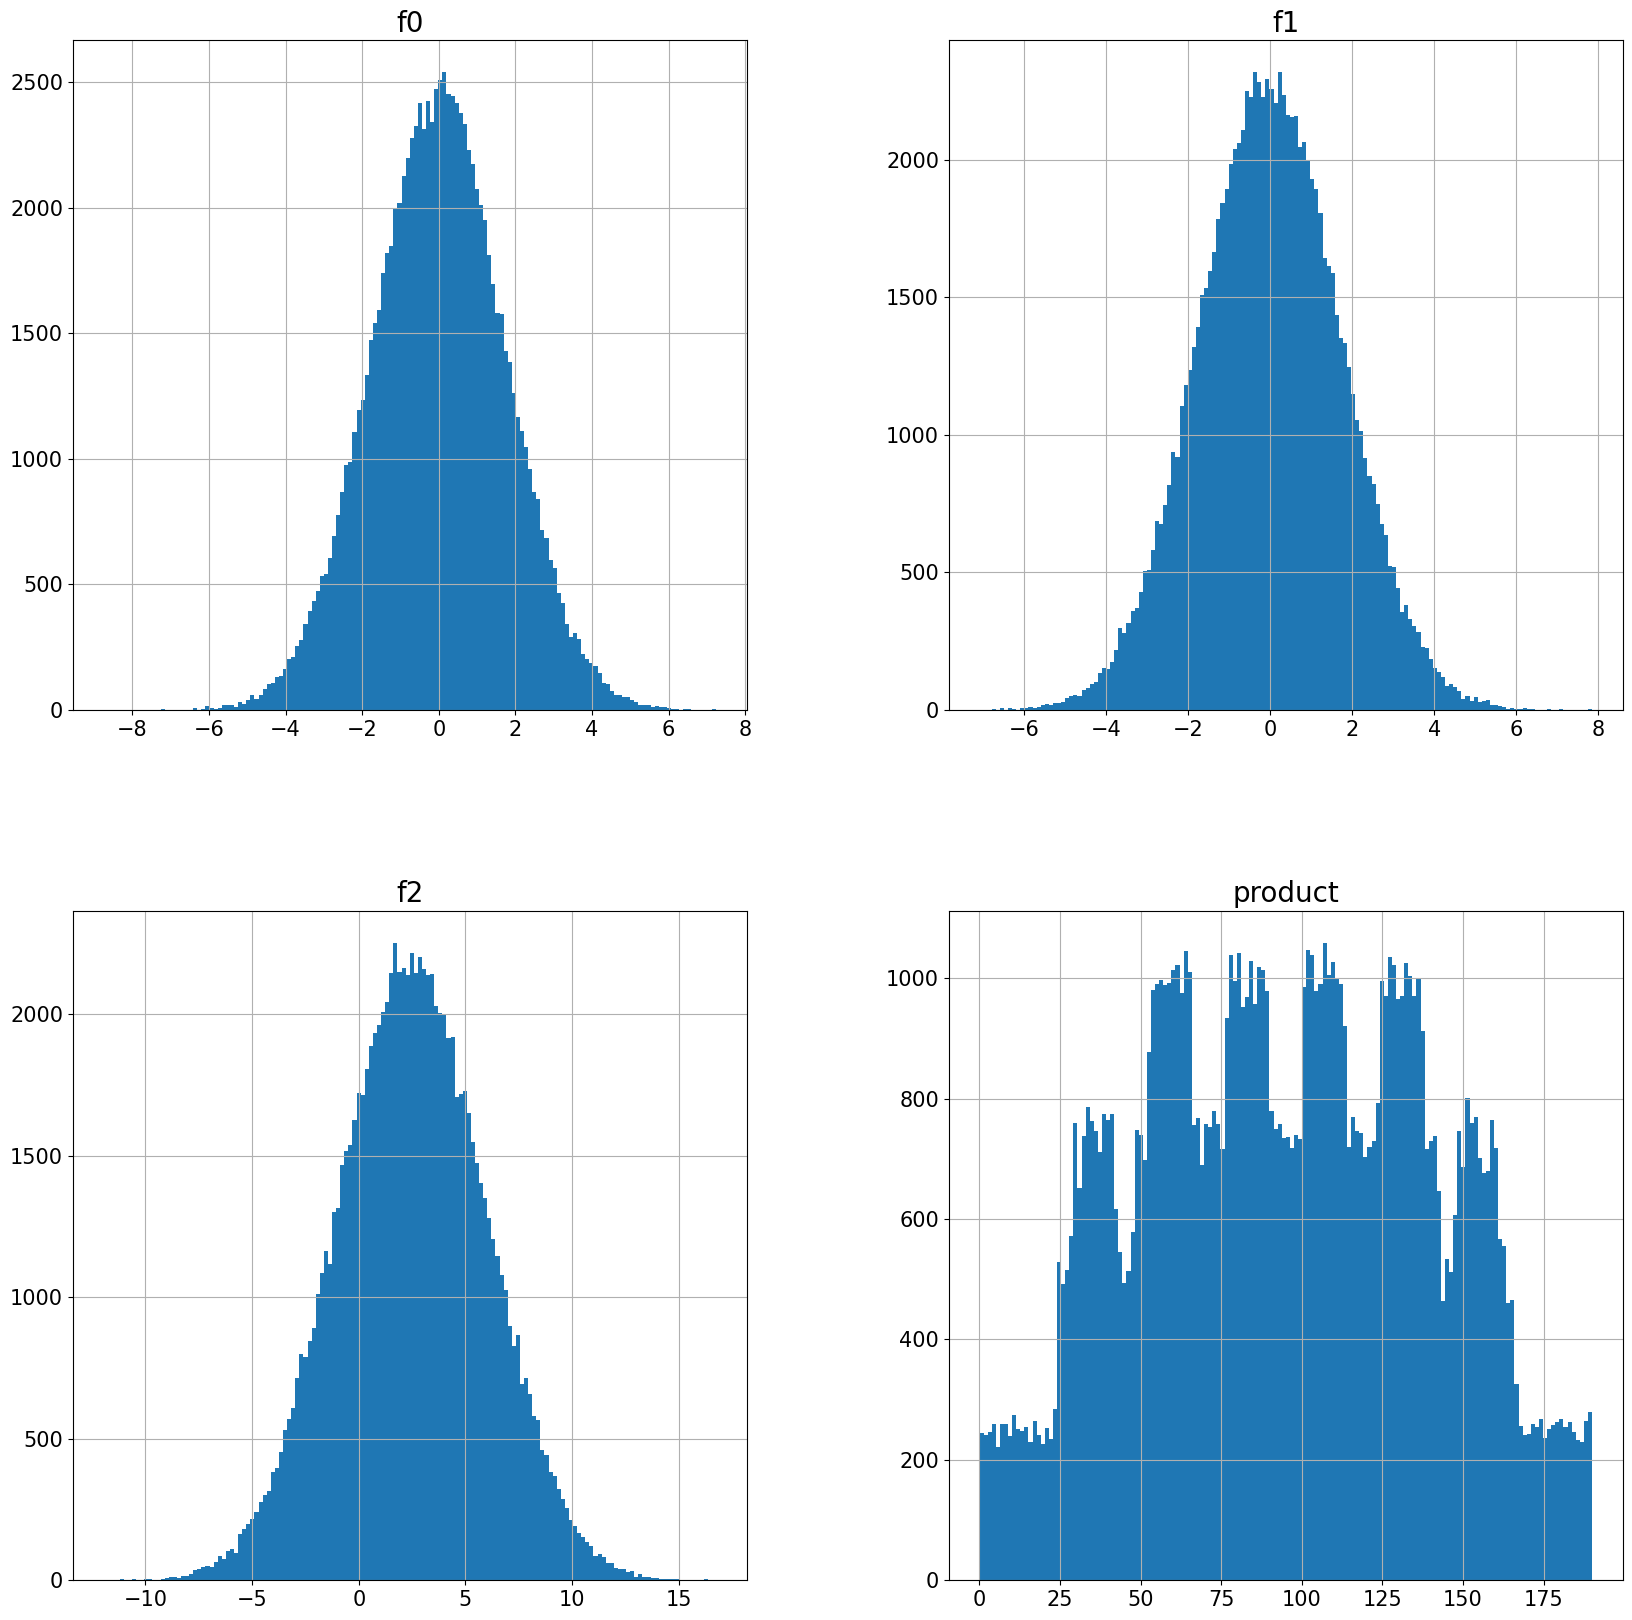

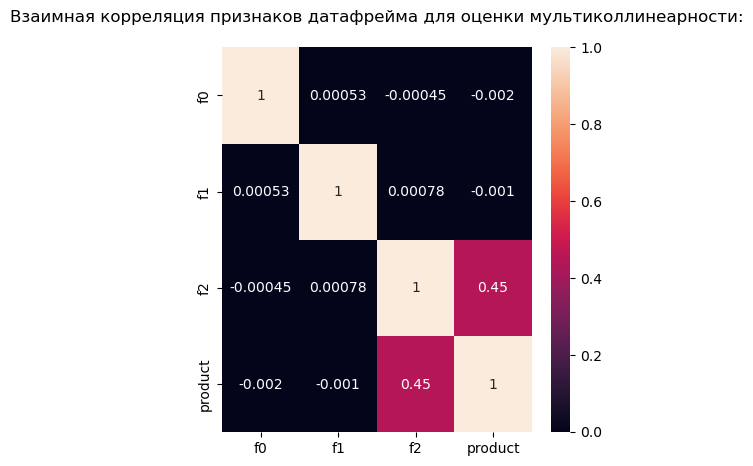

In [7]:
df_info(geo_data_2)

### Выводы после загрузки и изучения данных
После загрузки и изучения данных сделаны следующие промежуточные выводы:

* Размер файлов одинаковый. Набор данных: 100 000 строк х 5 столбцов.
* Названия столбцов в коррекции не нуждаются.
* Выяснено, что явных дубликатов в наших датафреймах нет, однако нашлись неявные дубликаты которые нужно обработать.
* Проверены типы данных, менять типы данных не нужно. Во всех 3-х датафреймах идентичные типы данных:
  * `id` — уникальный идентификатор скважины, состоящий из букв и цифр. Тип `object`.
  * `f0`, `f1`, `f2` — три признака лпределенных скважин. Тип `float64`.
  * `product` — объём запасов в скважине (тыс. баррелей). Тип `float64`.
* Нужно удалить признак id (уникальный идентификатор скважины), это признак, который влияет на результат классификации product (объём запасов в скважине, в тыс. баррелей).
* По гистограммам, значениям квантилей и среднего, видно выбивающиеся значения в данных столбцов `f2` и `product` в датафрейме `geo_data_1` по сравнению с датафреймом `geo_data_0` и `geo_data_2`, которые скорее всего будут мешать процессу обучения.
* Изучены данные на мультиколлинеарность признаков. В датасете `geo_data_1` обнаружили очень сильную мультиколлинеарность признаков , с коэффициентом корреляции Пирсона равным 1, зависимость между `f2` и `product`.
* Категориальных признаков нет.
* Для обучения моделей следует использовать линейную регрессию, поэтому Масштабирование численных признаков проводить не нужно.

### Подготовим данные

Обработаем неявные дубликаты в датафреймах:

In [8]:
def duplicates(df):
    print(df[df.duplicated(subset=['id']) == True])
    print(df[df.duplicated(subset=['id'], keep='last') == True])

In [9]:
duplicates(geo_data_0)

          id        f0        f1         f2     product
7530   HZww2  1.061194 -0.373969  10.430210  158.828695
41724  bxg6G -0.823752  0.546319   3.630479   93.007798
51970  A5aEY -0.180335  0.935548  -2.094773   33.020205
63593  QcMuo  0.635635 -0.473422   0.862670   64.578675
66136  74z30  1.084962 -0.312358   6.990771  127.643327
69163  AGS9W -0.933795  0.116194  -3.655896   19.230453
75715  Tdehs  0.112079  0.430296   3.218993   60.964018
90815  fiKDv  0.049883  0.841313   6.394613  137.346586
92341  TtcGQ  0.110711  1.022689   0.911381  101.318008
97785  bsk9y  0.378429  0.005837   0.160827  160.637302
          id        f0        f1         f2     product
931    HZww2  0.755284  0.368511   1.863211   30.681774
1364   bxg6G  0.411645  0.856830  -3.653440   73.604260
1949   QcMuo  0.506563 -0.323775  -2.215583   75.496502
3389   A5aEY -0.039949  0.156872   0.209861   89.249364
16633  fiKDv  0.157341  1.028359   5.585586   95.817889
21426  Tdehs  0.829407  0.298807  -0.049563   96

In [10]:
duplicates(geo_data_1)

          id         f0        f1        f2     product
41906  LHZR0  -8.989672 -4.286607  2.009139   57.085625
82178  bfPNe  -6.202799 -4.820045  2.995107   84.038886
82873  wt4Uk  10.259972 -9.376355  4.994297  134.766305
84461  5ltQ6  18.213839  2.191999  3.993869  107.813044
          id         f0         f1        f2     product
1305   LHZR0  11.170835  -1.945066  3.002872   80.859783
2721   bfPNe  -9.494442  -5.463692  4.006042  110.992147
5849   5ltQ6  -3.435401 -12.296043  1.999796   57.085625
47591  wt4Uk  -9.091098  -8.109279 -0.002314    3.179103


In [11]:
duplicates(geo_data_2)

          id        f0        f1        f2     product
43233  xCHr8 -0.847066  2.101796  5.597130  184.388641
49564  VF7Jo -0.883115  0.560537  0.723601  136.233420
55967  KUPhW  1.211150  3.176408  5.543540  132.831802
95090  Vcm5J  2.587702  1.986875  2.482245   92.327572
          id        f0        f1        f2     product
11449  VF7Jo  2.122656 -0.858275  5.746001  181.716817
28039  xCHr8  1.633027  0.368135 -2.378367    6.120525
44378  Vcm5J -1.229484 -2.439204  1.222909  137.968290
45404  KUPhW  0.231846 -1.698941  4.990775   11.716299


In [12]:
geo_data_0 = (geo_data_0.drop_duplicates(subset='id', keep='first')
              .reset_index(drop=True))
geo_data_1 = (geo_data_1.drop_duplicates(subset='id', keep='first')
              .reset_index(drop=True))
geo_data_2 = (geo_data_2.drop_duplicates(subset='id', keep='first')
              .reset_index(drop=True))

Проверим, правильно ли удалили неявные дубликаты:

In [13]:
def correctly_drop_duplicates(df):
    print(df)
    print("Количество неявных дубликатов датафрейма:", len(geo_data_0) - geo_data_0['id'].nunique(), "\n")

In [14]:
correctly_drop_duplicates(geo_data_0)

          id        f0        f1        f2     product
0      txEyH  0.705745 -0.497823  1.221170  105.280062
1      2acmU  1.334711 -0.340164  4.365080   73.037750
2      409Wp  1.022732  0.151990  1.419926   85.265647
3      iJLyR -0.032172  0.139033  2.978566  168.620776
4      Xdl7t  1.988431  0.155413  4.751769  154.036647
...      ...       ...       ...       ...         ...
99985  DLsed  0.971957  0.370953  6.075346  110.744026
99986  QKivN  1.392429 -0.382606  1.273912  122.346843
99987  3rnvd  1.029585  0.018787 -1.348308   64.375443
99988  7kl59  0.998163 -0.528582  1.583869   74.040764
99989  1CWhH  1.764754 -0.266417  5.722849  149.633246

[99990 rows x 5 columns]
Количество неявных дубликатов датафрейма: 0 



In [15]:
correctly_drop_duplicates(geo_data_1)

          id         f0         f1        f2     product
0      kBEdx -15.001348  -8.276000 -0.005876    3.179103
1      62mP7  14.272088  -3.475083  0.999183   26.953261
2      vyE1P   6.263187  -5.948386  5.001160  134.766305
3      KcrkZ -13.081196 -11.506057  4.999415  137.945408
4      AHL4O  12.702195  -8.147433  5.004363  134.766305
...      ...        ...        ...       ...         ...
99991  QywKC   9.535637  -6.878139  1.998296   53.906522
99992  ptvty -10.160631 -12.558096  5.005581  137.945408
99993  09gWa  -7.378891  -3.084104  4.998651  137.945408
99994  rqwUm   0.665714  -6.152593  1.000146   30.132364
99995  relB0  -3.426139  -7.794274 -0.003299    3.179103

[99996 rows x 5 columns]
Количество неявных дубликатов датафрейма: 0 



In [16]:
correctly_drop_duplicates(geo_data_2)

          id        f0        f1        f2     product
0      fwXo0 -1.146987  0.963328 -0.828965   27.758673
1      WJtFt  0.262778  0.269839 -2.530187   56.069697
2      ovLUW  0.194587  0.289035 -5.586433   62.871910
3      q6cA6  2.236060 -0.553760  0.930038  114.572842
4      WPMUX -0.515993  1.716266  5.899011  149.600746
...      ...       ...       ...       ...         ...
99991  4GxBu -1.777037  1.125220  6.263374  172.327046
99992  YKFjq -1.261523 -0.894828  2.524545  138.748846
99993  tKPY3 -1.199934 -2.957637  5.219411  157.080080
99994  nmxp2 -2.419896  2.417221 -5.548444   51.795253
99995  V9kWn -2.551421 -2.025625  6.090891  102.775767

[99996 rows x 5 columns]
Количество неявных дубликатов датафрейма: 0 



Удалим признак `id` в датафреймах:

In [17]:
geo_data_0 = geo_data_0.drop('id', axis=1)
geo_data_1 = geo_data_1.drop('id', axis=1)
geo_data_2 = geo_data_2.drop('id', axis=1)

### Выводы после подготовки данных:
* Удалили неявные дубликаты датафреймов;
* Удалили признак id.

## Обучим и проверим модели

Создадим переменные для сохранения предсказаний и правильных ответов на валидационной выборке:

In [18]:
predictions_valid = []
targets_valid = []
predictions_mean = [] # для сохранения предсказаний и визуализации

### Обучение модели

Создадим функцию для разбития данных, обучения, предсказания и расчета среднего запаса предсказанного сырья и RMSE модели:

In [19]:
def learning_data(df):

# Выделим из переданного датафрейма обучающие признаки features и целевой признак target: 
    features = df.drop(["product"], axis=1)
    target = df["product"]
    
# Разобьём данные на обучающую и валидационную выборки в соотношении 75:25:    
    features_train, features_valid, target_train, target_valid = \
        train_test_split(features, target, test_size=0.25, random_state=RFN)

# Создадим и обучим модель:
    model = LinearRegression()
    model.fit(features_train, target_train)
    
# Cделаем предсказания на валидационной выборке:    
    predictions = model.predict(features_valid)

# список предсказаний по объёму сырья в скважине и список правильных ответов добавим 
# в созданные переменные для их сохранения
    predictions_valid.append(predictions) 
    predictions_mean.append(round(predictions.mean(), 2))
    targets_valid.append(target_valid.reset_index(drop=True))
           
# Напечатаем средний запас предсказанного сырья и RMSE модели:  
    print(f"Средний запас предсказанного сырья: {round(predictions.mean(), 2)} тыс. баррелей.")
    RMSE = mean_squared_error(predictions, target_valid)**0.5
    print(f"RMSE модели: {round(RMSE,2)}")

### Проверка модели

In [20]:
learning_data(geo_data_0)

Средний запас предсказанного сырья: 92.79 тыс. баррелей.
RMSE модели: 37.85


In [21]:
learning_data(geo_data_1)

Средний запас предсказанного сырья: 69.18 тыс. баррелей.
RMSE модели: 0.89


In [22]:
learning_data(geo_data_2)

Средний запас предсказанного сырья: 94.87 тыс. баррелей.
RMSE модели: 40.08


In [23]:
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return f"{round(pct, 2)}%\n({absolute} тыс. баррелей)"

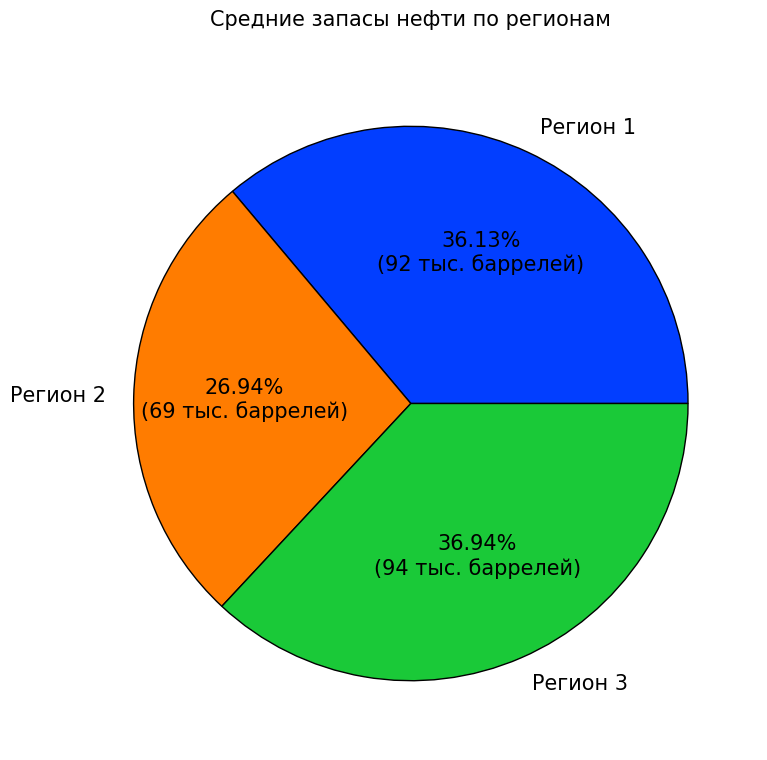

In [24]:
colors = sns.color_palette('bright')[0:3]
plt.figure(figsize=(9,9))
plt.title('Средние запасы нефти по регионам' + "\n", size=15)
plt.pie(predictions_mean, 
        textprops={'fontsize': 15},
        labels = ['Регион 1', 'Регион 2', 'Регион 3'],
        autopct = lambda pct: func(pct, predictions_mean),
        wedgeprops=dict(width=1, edgecolor='black'), 
        colors = colors)
plt.show() 

### Выводы после обучения и проверки модели:

* Данные разделены на обучающую и валидационную выборки в соотношении `75:25`;
* Созданы и обучены модели `LinearRegression`;
* Выполнены предсказания на валидационной выборке;
* Сделаны предсказания по объёму сырья в скважинах;
* Созданы:
  * список предсказаний по объёму сырья predictions_valid;
  * список правильных ответов targets_valid;
* Рассчитаны значения среднего запаса предсказанного сырья и RMSE моделей:
  * для датафрейма `geo_data_1`, `RMSE модели = 0.89`. 
  Столь низкие значения, видимо связаны с переобучением модели и высокой мультиколлиниарностью между `f2` и `product`;
  * для датафрейма `geo_data_0` и `geo_data_2` получены значения `RMSE = 36.13` и `RMSE = 37.06`. Значения слишком велики по сравнению с средним запасом предсказанного сырья и говорит о сильном разбросе данных в валидационных выборках этих датафреймов.
  * Для `geo_data_1` имеем самые низкие запасы предсказанного сырья. Всего `68 тыс.` баррелей против `92 - 94 тыс.` для других регионов.

## Подготовка к расчёту прибыли

### Рассчет  объёма сырья для безубыточной разработки новой скважины.

In [51]:
break_even = DEVELOPMENT_BUDGET / COST_BARREL

In [53]:
f"Точка безубыточности: {round(break_even, 2)} тыс. баррелей на каждый регион."

'Точка безубыточности: 22222.22 тыс. баррелей на каждый регион.'

In [54]:
average_break_even = break_even / BEST_REGION_POINTS

In [55]:
f"Средний объем нефти в скважине, требуемый для безубыточной работы: {round(average_break_even, 2)} тыс. баррелей."

'Средний объем нефти в скважине, требуемый для безубыточной работы: 111.11 тыс. баррелей.'

Сравним полученный объём сырья со средним запасом в каждом регионе:

In [56]:
def get_df_region(df):
    name =[x for x in globals() if globals()[x] is df][0]
    for i in range(3):
        if name[-1] == str(i):
            return 'регионе ' + str(i + 1)
        else:
            pass

In [57]:
def comparison(df, avg = average_break_even):
    if df['product'].mean() > avg:
        print(f'В {get_df_region(df)} средний запас сырья больше объема сырья для безубыточной работы.')
    elif df['product'].mean() < avg:
        print(f'В {get_df_region(df)} средний запас сырья меньше объема сырья для безубыточной работы.')
    elif df['product'].mean() == avg:
        print(f'В {get_df_region(df)} средний запас сырья и объем сырья для безубыточной работы равны.')

In [58]:
comparison(geo_data_0)

В регионе 1 средний запас сырья меньше объема сырья для безубыточной работы.


In [59]:
comparison(geo_data_1)

В регионе 2 средний запас сырья меньше объема сырья для безубыточной работы.


In [60]:
comparison(geo_data_2)

В регионе 3 средний запас сырья меньше объема сырья для безубыточной работы.


### Выводы после подготовки к расчёту прибыли:
* Среднее значение запаса сырья по всем скважинам для каждого из регионов меньше, чем точка безубыточности: 111 тыс. баррелей (объём сырья для безубыточной разработки новой скважины).
* Разработку всех скважин вести нерентабельно.
* Из всех скважин нужно выбрать всего 200 лучших с максимальными запасами и вкладывать деньги в их запуск и производственную деятельность.
* Cреднее ожидаемое значение сырья в точке по регионам рассчитано на основе 25 000 точек, из которых мы можем разработать только 200 - само собой, что среди них могут оказать как плохие, так и хорошие скважины с точки зрения запаса в них продукта.
* Отбирая точки и считая финансовый результат работы в них, мы можем оценить прибыль и риски работы в регионе - для этого применим в дальнейшем метод бутстрапирования.

## Расчёт прибыли и рисков 

### Функция для расчёта прибыли по выбранным скважинам и предсказаниям модели

Напишем функцию расчёта прибыли и выберем для каждого региона лучшие 200 скважин по значению предсказанных запасов нефти:

In [61]:
def calc_profit(target, predictions):
    predictions_sorted = predictions.sort_values(ascending=False)
    target_selected = target[predictions_sorted.index][:BEST_REGION_POINTS]

    return target_selected.sum() * COST_BARREL - DEVELOPMENT_BUDGET

In [62]:
def get_df_name(df): 
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [63]:
profit_top_200 = []
region_top_200 = ['Регион 1', 'Регион 2', 'Регион 3']

In [64]:
def value_region(df):
    for i in range(3):
        if get_df_name(df)[-1] == str(i):
            predictions_sample = pd.Series(predictions_valid[i],index=targets_valid[i].index)      
            profit = calc_profit(targets_valid[i], predictions_sample)
            profit_top_200.append(round(profit/1000000, 2))
            print(f'В {get_df_region(df)} прибыль с 200 лучших скважин составляет {round(profit/1000000, 2)} млрд. руб..')
        else:
            pass

In [65]:
value_region(geo_data_0)

В регионе 1 прибыль с 200 лучших скважин составляет 3.37 млрд. руб..


In [66]:
value_region(geo_data_1)

В регионе 2 прибыль с 200 лучших скважин составляет 2.42 млрд. руб..


In [67]:
value_region(geo_data_2)

В регионе 3 прибыль с 200 лучших скважин составляет 2.5 млрд. руб..


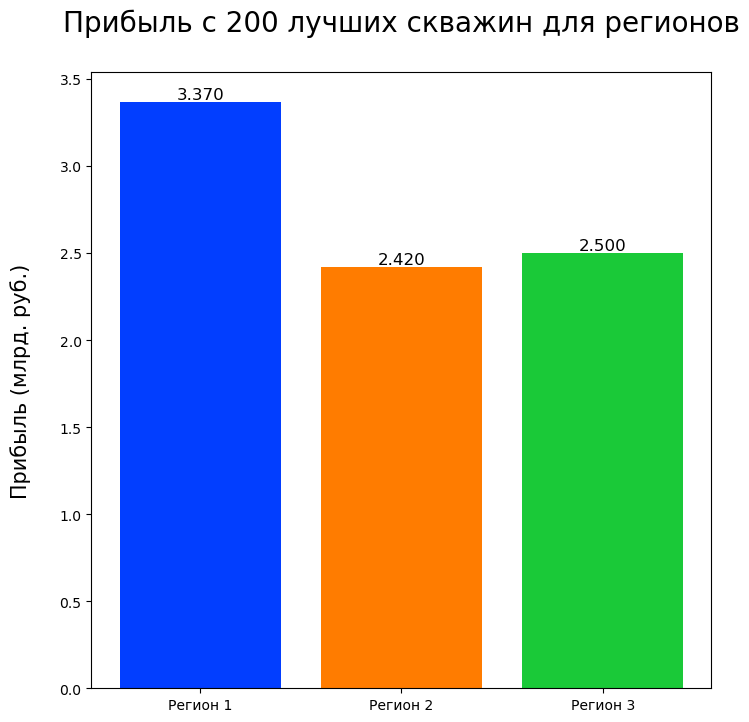

In [68]:
fig, ax = plt.subplots(figsize=(8, 8))
bar_container = ax.bar(region_top_200, profit_top_200, color=colors)
ax.set_ylabel('Прибыль (млрд. руб.)' + '\n', fontsize=15)
ax.set_title('Прибыль с 200 лучших скважин для регионов' + '\n', fontsize=20)
ax.bar_label(bar_container, fmt='{:,.3f}', fontsize=12)
plt.show()

### Выводы после расчёта прибыли:

* Написали функцию расчёта прибыли;
* Выбрали для каждого региона лучшие 200 скважин по значению предсказанных запасов нефти;
* Все три региона потенциально прибыльные.

## Расчитаем прибыль и риски для каждого региона.

Создадим функцию для расчета прибыли и рисков с применением техники Bootstrap с 1000 выборок, чтобы найти распределение прибыли.

In [69]:
mean_profit = []
risks = []

In [71]:
predictions_valid[0]

array([103.95037196,  73.6878687 , 101.01528767, ...,  78.44465303,
        71.08276801,  66.05485384])

In [72]:
targets_valid[0]

0        123.566299
1         63.442039
2         88.718000
3         51.422060
4        102.569999
            ...    
24993     32.531740
24994    139.062332
24995     55.953481
24996     87.222042
24997    138.866063
Name: product, Length: 24998, dtype: float64

In [73]:
def value_risk_and_profit(df):
    for i in range(3):
        if get_df_name(df)[-1] == str(i):
            predictions = pd.Series(predictions_valid[i],index=targets_valid[i].index)
            target = targets_valid[i] 
        else:
            pass
    profit_values = []
    for _ in range(QUANTITY_BOOTSTRAP):
        
        target_sample  = target.sample(REGION_POINTS, replace=True, random_state=STATE_RFN)

        predictions_sample = predictions[target_sample.index]

        target_sample = target_sample.reset_index(drop = True)
        predictions_sample = pd.Series(predictions_sample)
        predictions_sample = predictions_sample.reset_index(drop = True)
              
        profit_values.append(calc_profit(target_sample, predictions_sample))
 
    profit_values = pd.Series(profit_values)
    
    
    mean_profit_value = round(profit_values.mean()/1000, 2)
    mean_profit.append(mean_profit_value)
    
    confidence_interval_low = round(profit_values.quantile(0.025)/1000, 2)
    confidence_interval_high = round(profit_values.quantile(0.975)/1000, 2)
    
    
    risk = round((profit_values < 0).mean()*100, 1)
    risks.append(risk)
    
    print(f"Средняя прибыль: {mean_profit_value} млн.руб.")
    print(f"95%-ый доверительный интервал: от {confidence_interval_low} млн.руб до {confidence_interval_high} млн.руб.")
    print (f'Процент вероятности убытка в данном регионе составит {risk} %')    

In [74]:
value_risk_and_profit(geo_data_0)

Средняя прибыль: 391.48 млн.руб.
95%-ый доверительный интервал: от -100.62 млн.руб до 924.81 млн.руб.
Процент вероятности убытка в данном регионе составит 7.3 %


In [75]:
value_risk_and_profit(geo_data_1)

Средняя прибыль: 479.25 млн.руб.
95%-ый доверительный интервал: от 98.11 млн.руб до 865.28 млн.руб.
Процент вероятности убытка в данном регионе составит 1.0 %


In [76]:
value_risk_and_profit(geo_data_2)

Средняя прибыль: 346.19 млн.руб.
95%-ый доверительный интервал: от -215.28 млн.руб до 853.26 млн.руб.
Процент вероятности убытка в данном регионе составит 9.9 %


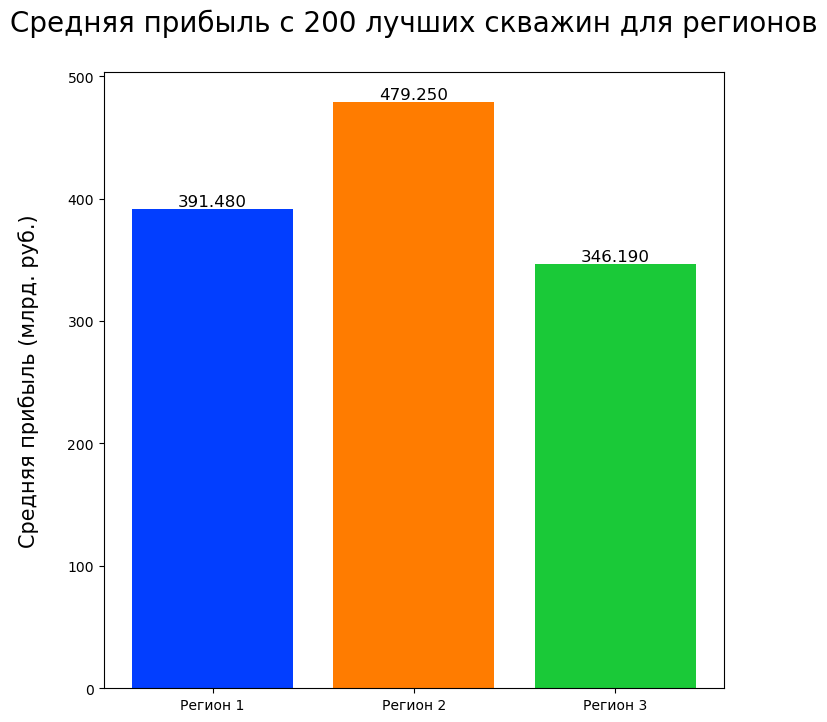

In [77]:
fig, ax = plt.subplots(figsize=(8, 8))
bar_container = ax.bar(region_top_200, mean_profit, color=colors)
ax.set_ylabel('Средняя прибыль (млрд. руб.)' + '\n', fontsize=15)
ax.set_title('Средняя прибыль с 200 лучших скважин для регионов' + '\n', fontsize=20)
ax.bar_label(bar_container, fmt='{:,.3f}', fontsize=12)
plt.show()

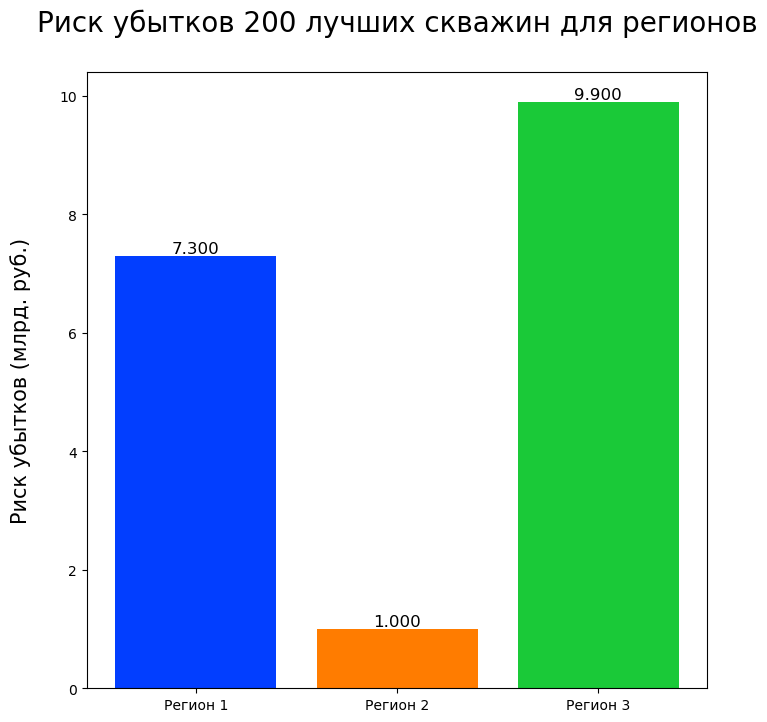

In [78]:
fig, ax = plt.subplots(figsize=(8, 8))
bar_container = ax.bar(region_top_200, risks, color=colors)
ax.set_ylabel('Риск убытков (млрд. руб.)' + '\n', fontsize=15)
ax.set_title('Риск убытков 200 лучших скважин для регионов' + '\n', fontsize=20)
ax.bar_label(bar_container, fmt='{:,.3f}', fontsize=12)
plt.show()

### Выводы после расчёта прибыли и рисков для каждого региона.

* Только лишь в регионе 2 `geo_data_1` вероятность убытков меньше `1%`.
* Средняя прибыль в регионе 2 составляет более `450 млн рублей`.
* Для региона 2 95%-й доверительный интервал не содержит отрицательных значений.
* Наименьший риск получения убытков при разработке 200 скважин определен для региона №2.

## Общий вывод
По результатам исследования можно отметить следующие факты и сделать следующие выводы:

1. Данные были изучены и подготовлены к дальнейшим исследованиям.

0. Построена модель по всему объему данных после разделения на обучающую и валидационную выборки. Обнаружено:
   * Среднее значение запаса сырья по полному количеству скважин для каждого из регионов меньше, чем точка безубыточности: 111 тыс. баррелей (объём сырья для безубыточной разработки новой скважины).
   * Средний запас ресурсов по регионам недостаточен даже для окупаемости вложений на разработку.
   * Принимается решение о том, что разработку сразу всех скважин вести нерентабельно.
   * Из всех скважин нужно выбрать всего 200 лучших с максимальными запасами и вкладывать деньги в их запуск и производственную деятельность.
0. Проведена оценка по 200-м лучшим скважинам в каждом из регионов. Получены следующие результаты:

| Регион	|  Прибыль (млрд. руб)|
|:---------:|:-------------------:|
| Регион 1  |  3.370              |
| Регион 2  |  2.420              |
| Регион 3  |  2.500              |

4. Выполнены предсказания при помощи линейной регрессии, а так же применена технологиа Bootstrap с разделением каждого предсказанного значения прибыли по регионам на 1000 выборок:

| Регион	|  Средняя прибыль от 200 лучших скважин (млн. руб.)|
|:---------:|:-------------------------------------------------:|
| Регион 1  |  394.38                                           |
| Регион 2  |  475.78                                           |
| Регион 3  |  347.88                                           |

| Регион	|  95%-ый доверительный интервал (млн. руб.)        |
|:---------:|:-------------------------------------------------:|
| Регион 1  |  -168.67 ... 935.49                               |
| Регион 2  |  95.9 ... 864.42                                  |
| Регион 3  |  -176.52 ... 875.1                                |

| Регион	|  Процент вероятности убытка в данном регионе составит (%)|
|:---------:|:--------------------------------------------------------:|
| Регион 1  |  8.0                                                     |
| Регион 2  |  0.8                                                     |
| Регион 3  |  10.6                                                    |

5. Определен доверительный интервал получения прибыли в 95%.

0. Несмотря на сравнительно меньшие запасы сырья, по сравнению с другими регионами (всего 68 тыс баррелей против 92 и 94), средняя доходность с 200 лучших скважин во регионе №2 прогнозируется выше других, при наименьших рисках.

0. Наименьший риск получения убытков при разработке 200 скважин определен для региона №2.

0. При величине запасов на уровне 68 (тыс. баррелей), по показателю наименьшего риска (<1%) c прибыльностью на уровне 460 (млн. руб.) выбирается модель разработки 200 скважин в регионе №2.